In [1]:
%run ../../multibench.py

In [2]:
!mccortex

usage: mccortex <K> [<cmd> ...]
  Wrapper to find the correct mccortex binary given kmer size (K)


In [6]:
import sys
import os
import shutil
import numpy as np
import glob

# Move two upper directories, import benchmark, revert cwd
sys.path.append("../..")
import cmdbench
sys.path.pop()

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

input_dir = 'input'
input_files_1 = [os.path.basename(f) for f in glob.glob('input/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
print(input_samples)

bigsi_dir = 'bigsi-data'

['PNUSAL001024', 'SH14-021', 'SH14-015', 'SH12-011', 'SH12-001', '2014D-0068', 'SH14-025', 'D7322', 'SH14-004', 'MOD1_LS998', '2014D-0070', 'PNUSA000196', 'SH14-003', 'SH12-012', 'SH10-014', 'SH12-010', 'PNUSAL000870', 'SH12-006', 'D7331', 'SH14-024', 'MOD1_LS989', 'SH12-013', 'CFSAN023467', 'SH14-005', 'SH14-014', 'D7334', 'MOD1_LS996', 'SH14-013', 'SH09-29', 'SH13-003', 'SH14-009', 'SH14-016', 'SH12-004', 'SH11-001', 'SH14-027', 'SH12-005', 'SH14-011', 'PNUSA000195', 'SH13-004', 'SH14-010', 'MOD1_LS1005', 'SH14-019', 'SH14-028', 'CFSAN023469', 'MOD1_LS995', 'D7316', 'MOD1_LS1008', 'SH13-001', 'SH14-012', '2014D-0067', 'SH14-001', 'SH08-001', 'PNUSA000194', 'MOD1_LS997', 'CFSAN023464', 'PNUSAL000957', 'MOD1_LS1011', 'D7323', 'SH10-30', 'D7330', 'D7327', 'SH11-002', 'SH13-002', 'SH12-007', 'SH13-006', 'SH14-023', 'CFSAN023466', 'SH14-022', 'SH14-008', 'D7321', '2014D-0189', 'SH12-009', 'D7329', 'SH10-002', 'D7333', 'MOD1_LS1003', 'CFSAN023471', 'SH14-017', 'MOD1_LS1009', 'MOD1_LS994', 

In [7]:
def clean_if_exists(path):
    if os.path.exists(path):
        if(os.path.isfile(path)):
            os.remove(path)
        else:
            shutil.rmtree(path)
            os.mkdir(path)
def get_last_n_lines(string, n):
    return "\n".join(string.split("\n")[-n:])

In [8]:
%%bash
# You might need to run this before starting jupyter notebook in your shell
export BIGSI_CONFIG=berkleydb.yaml

In [9]:
sample_sizes = range(0, 17 + 1)

In [10]:
import cmdbench

In [11]:
def reset_func():
    # Delete indexed data
    os.system("bigsi delete")

    # Delete all saved bigsi data
    clean_if_exists("bigsi-data")
    clean_if_exists("test-berkeley.db")
    
def benchmark_list_to_results(benchmark_firsts_list):
    return {
        "memory": max(list(map(lambda result: result.memory.max, benchmark_firsts_list))),
        "disk_read": max(list(map(lambda result: result.disk.read_chars, benchmark_firsts_list))),
        "disk_write": max(list(map(lambda result: result.disk.write_chars, benchmark_firsts_list))),
        "runtime": sum(list(map(lambda result: result.process.execution_time, benchmark_firsts_list)))
    }
def sampling_func(input_size):
    return input_samples[:input_size]

mccortex_command = {
    "command": "mccortex 31 build --nkmers 74000000 --threads 8 --kmer 31 --mem 20G --sample % --seq2 input/%_1.fastq.gz:input/%_2.fastq.gz bigsi-data/%.ctx",
    "parallel_args": "-j 8 -I%"
}

bigsi_bloom_command = {
    "command": "bigsi bloom -c berkleydb.yaml bigsi-data/%.ctx bigsi-data/%.bloom",
    "parallel_args": "-j 8 -I%"
}

bigsi_build_command = {
    "command": lambda sample_files: "bigsi build -c berkleydb.yaml" + " -s " + (" -s ").join(sample_files) + " " + " ".join(list(map(lambda sample_file: "bigsi-data/%s.bloom" % sample_file, sample_files))),
}

query_repeat_count = 2
query_sequence = "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG"

query_command = {
    "command": "bigsi search % --config berkleydb.yaml -t 0.8",
    "parallel_argfiles": [query_sequence] * query_repeat_count,
    "parallel_args": "-j 1 -I%"
}

multibench_results, debug_str = multi_cmdbench({
"index": [mccortex_command, bigsi_bloom_command, bigsi_build_command],
"query": [query_command]
}, reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark_list_to_results, active_output_print = True, progress_bar = True)


>>>>>>>>>>>>>
parallel -j 8 -I% mccortex 31 build --nkmers 74000000 --threads 8 --kmer 31 --mem 20G --sample % --seq2 input/%_1.fastq.gz:input/%_2.fastq.gz bigsi-data/%.ctx ::: 

STDOUT: 
-------------
STDERR: 
<<<<<<<<<<<<<

>>>>>>>>>>>>>
parallel -j 8 -I% bigsi bloom -c berkleydb.yaml bigsi-data/%.ctx bigsi-data/%.bloom ::: 

STDOUT: 
-------------
STDERR: 
<<<<<<<<<<<<<

>>>>>>>>>>>>>
bigsi build -c berkleydb.yaml -s  

STDOUT: 
-------------
STDERR: usage: bigsi-v0.3.1 build [-h] [-s SAMPLES] [-c CONFIG]
                          [bloomfilters [bloomfilters ...]]
bigsi-v0.3.1 build: error: argument -s/--samples: expected one argument

<<<<<<<<<<<<<

>>>>>>>>>>>>>
parallel -j 1 -I% bigsi search % --config berkleydb.yaml -t 0.8 ::: GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG

STDOUT: 
-------------
STDERR: /home/manzik/anaconda3/envs/bigsi_mccortex/lib/python3.7/site-packages/bigsi

STDOUT: 
-------------
STDERR: /home/manzik/anaconda3/envs/bigsi_mccortex/lib/python3.7/site-packages/bigsi/__main__.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(infile)

<<<<<<<<<<<<<

>>>>>>>>>>>>>
bigsi build -c berkleydb.yaml -s PNUSAL001024 bigsi-data/PNUSAL001024.bloom



Process Process-21:
Traceback (most recent call last):
  File "/home/manzik/anaconda3/lib/python3.7/site-packages/psutil/_common.py", line 449, in wrapper
    ret = self._cache[fun]
Process Process-20:
AttributeError: _cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/manzik/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/manzik/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/manzik/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/manzik/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/manzik/Documents/cmdbench/repo/bioinformatics/../cmdbench/core.py", line 220, in collect_time_series
    current_children =

KeyboardInterrupt: 

In [13]:
# print(debug_str)

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'memory': 855875584.0, 'disk_read': 454336865327.0, 'disk_write': 454193271504.0, 'runtime': 867.86}, {'memory': 1633312768.0, 'disk_read': 454344661247.0, 'disk_write': 454191821679.0, 'runtime': 870.91}, {'memory': 2460299264.0, 'disk_read': 454356336079.0, 'disk_write': 454194213902.0, 'runtime': 938.4}, {'memory': 3070812160.0, 'disk_read': 454365749919.0, 'disk_write': 454194394285.0, 'runtime': 915.1}, {'memory': 3799830528.0, 'disk_read': 454378792815.0, 'disk_write': 454198080844.0, 'runtime': 1026.09}, {'memory': 4596817920.0, 'disk_read': 454385892415.0, 'disk_write': 454195992043.0, 'runtime': 947.44}, {'memory': 5779120128.0, 'disk_read': 454386487567.0, 'disk_write': 454187468426.0, 'runtime': 968.4599999999999}]


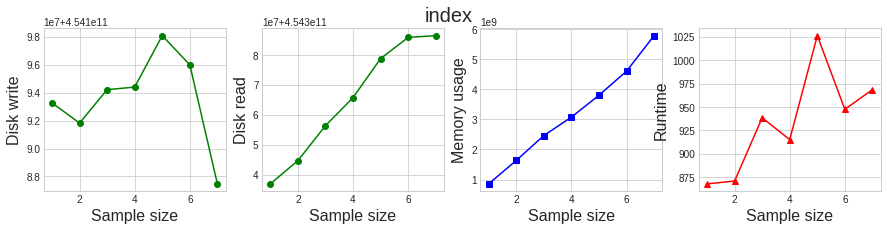

In [25]:
# Indexing Plots
plot_resources(multibench_results, sample_sizes, "index")

[{'memory': 244711424.0, 'disk_read': 17437538.0, 'disk_write': 634865.0, 'runtime': 0.9}, {'memory': 243527680.0, 'disk_read': 17436420.0, 'disk_write': 634789.0, 'runtime': 0.88}, {'memory': 243212288.0, 'disk_read': 17436302.0, 'disk_write': 634704.0, 'runtime': 0.9}, {'memory': 244396032.0, 'disk_read': 17440142.0, 'disk_write': 643198.0, 'runtime': 0.97}, {'memory': 243142656.0, 'disk_read': 17436315.0, 'disk_write': 634671.0, 'runtime': 0.92}, {'memory': 243564544.0, 'disk_read': 17445976.0, 'disk_write': 635158.0, 'runtime': 0.91}, {'memory': 244015104.0, 'disk_read': 17444762.0, 'disk_write': 635071.0, 'runtime': 0.99}]


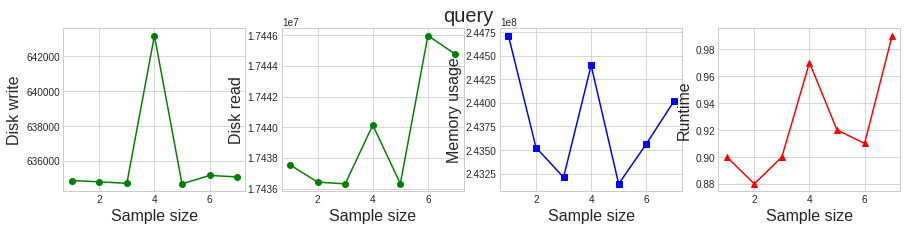

In [26]:
# Querying Plots
plot_resources(multibench_results, sample_sizes, "query")